In [66]:
import ps_calculation
import numpy as np
import matplotlib.pyplot as plt
import pyuvdata
import importlib
importlib.reload(ps_calculation)

<module 'ps_calculation' from '/opt/devel/rbyrne/DeltaPS/ps_calculation.py'>

In [61]:
filepath = "/lustre/pipeline/cosmology/41MHz/2026-01-12/12/20260112_120008_41MHz.ms"

In [62]:
ps_2d, kperp_bin_edges, delay_axis, freq_array = ps_calculation.calculate_ps(
    filepath,
)

Setting telescope_location to value in known_telescopes for OVRO-LWA.
The uvw_array does not match the expected values given the antenna positions. The largest discrepancy is 6.7540101049759755 meters. This is a fairly common situation but might indicate an error in the antenna positions, the uvws or the phasing.
The uvw_array does not match the expected values given the antenna positions. The largest discrepancy is 6.7540101049759755 meters. This is a fairly common situation but might indicate an error in the antenna positions, the uvws or the phasing.
invalid value encountered in divide


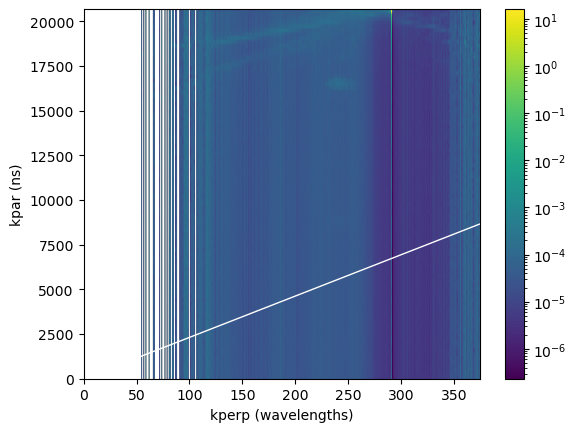

In [63]:
avg_wl = 3e8 / np.mean(freq_array)
plt.imshow(
    ps_2d[:, :, 0].T,
    origin="lower",
    interpolation=None,
    extent=(
        np.min(kperp_bin_edges),
        np.max(kperp_bin_edges),
        0,
        np.max(delay_axis) * 1e9,
    ),
    aspect="auto",
    norm="log",
)
plt.plot(
    kperp_bin_edges,
    kperp_bin_edges * avg_wl / 3e8 * 1e9,
    "-",
    color="white",
    linewidth=1,
)
plt.xlabel("kperp (wavelengths)")
plt.ylabel("kpar (ns)")
plt.colorbar()

In [64]:
uv = pyuvdata.UVData()
uv.read(filepath)
uv.select(polarizations=[-5, -6])
uv.phase_to_time(np.mean(uv.time_array))
uv.conjugate_bls(convention="u>0")
uv.flag_array[np.where(~np.isfinite(uv.data_array))] = True  # Flag all nan-ed data

Setting telescope_location to value in known_telescopes for OVRO-LWA.
The uvw_array does not match the expected values given the antenna positions. The largest discrepancy is 6.7540101049759755 meters. This is a fairly common situation but might indicate an error in the antenna positions, the uvws or the phasing.
The uvw_array does not match the expected values given the antenna positions. The largest discrepancy is 6.7540101049759755 meters. This is a fairly common situation but might indicate an error in the antenna positions, the uvws or the phasing.


In [67]:
freq = uv.freq_array[0]
app_sky = ps_calculation.dft_visibilities(
    uv.data_array[:, 0, 0],
    uv.uvw_array[:, :2] * freq / 3e8,
)

In [68]:
np.shape(app_sky)

(1100, 1100)

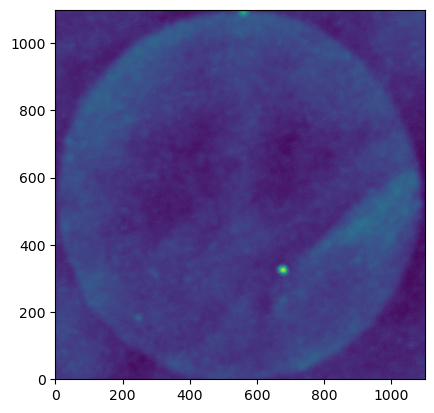

In [69]:
plt.imshow(app_sky.T, origin="lower", interpolation=None)